# Logistic Regression Model

**Note**: This notebook is designed to run on CPU (no GPU) runtime.

**[LRM-01]**

Install libraries.

In [1]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.6/185.6 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 5.5 MB/s eta 0:00:00
flax                          0.6.1
jax                           0.3.25
jaxlib                        0.3.25+cuda11.cudnn805
optax                         0.1.3


**[LRM-02]**

Import modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state

plt.rcParams.update({'font.size': 12})

**[LRM-03]**

Generate a training dateset.

In [3]:
key, key1, key2, key3 = random.split(random.PRNGKey(0), 4)

n0, mu0, variance0 = 20, [10, 11], 20
data0 = random.multivariate_normal(
    key1, jnp.asarray(mu0), jnp.eye(2)*variance0 ,jnp.asarray([n0]))
data0 = jnp.hstack([data0, jnp.zeros([n0, 1])])

n1, mu1, variance1 = 15, [18, 20], 22
data1 = random.multivariate_normal(
    key2, jnp.asarray(mu1), jnp.eye(2)*variance1 ,jnp.asarray([n1]))
data1 = jnp.hstack([data1, jnp.ones([n1, 1])])

data = random.permutation(key3, jnp.vstack([data0, data1]))

train_x, train_t = jnp.split(data, [2], axis=1)

**[LRM-04]**

`train_x` contains coordinates $(x_1, x_2)$ of the training data.

In [4]:
train_x[:10]

DeviceArray([[16.01956  , 24.724857 ],
             [16.187202 , 19.359642 ],
             [ 9.809063 ,  5.0806694],
             [ 3.0660596,  4.5652065],
             [ 9.432011 , 19.016624 ],
             [ 6.4253054, 16.873808 ],
             [16.608196 , 19.436    ],
             [11.022198 , 14.349034 ],
             [ 5.7192607, 18.221735 ],
             [13.060467 , 12.594545 ]], dtype=float32)

**[LRM-05]**

`train_t` contains corresponding lables $t = 0,\,1$.

In [5]:
train_t[:10]

DeviceArray([[1.],
             [0.],
             [0.],
             [0.],
             [0.],
             [0.],
             [0.],
             [1.],
             [0.],
             [0.]], dtype=float32)

**[LRM-06]**

Define a model to predict the probability of $t=1$.

In [6]:
class LogisticRegressionModel(nn.Module):
    @nn.compact
    def __call__(self, x, get_logits=False):
        x = nn.Dense(features=1)(x)
        if get_logits:
            return x
        x = nn.sigmoid(x)
        return x

**[LRM-07]**

Generate initial parameter values.

In [7]:
key, key1 = random.split(key)
variables = LogisticRegressionModel().init(key1, train_x)
variables

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[-0.46314612],
                         [-0.82383525]], dtype=float32),
            bias: DeviceArray([0.], dtype=float32),
        },
    },
})

**[LRM-08]**

Create a training state object.

In [8]:
state = train_state.TrainState.create(
    apply_fn=LogisticRegressionModel().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001))

**[LRM-09]**

Define a loss function as the binary cross entropy. This function also returns the accuracy of the model.

In [9]:
@jax.jit
def loss_fn(params, state, inputs, labels):
    logits = state.apply_fn({'params': params}, inputs, get_logits=True)
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.sign(logits) == jnp.sign(labels-0.5))
    return loss, acc

**[LRM-10]**

Define a function to apply a single training step that returns a new training state.

**Note**: When the `loss_fn()` returns auxiliary values in additon to the loss value, you should specify `has_aux=True` for `jax.value_and_grad()`.

In [10]:
@jax.jit
def train_step(state, inputs, labels):
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        state.params, state, inputs, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, acc

**[LRM-11]**

Repeat applying the training step.

In [11]:
%%time
loss_history, acc_history = [], []
for step in range(1, 10001):
    state, loss, acc = train_step(state, train_x, train_t)
    loss_history.append(jax.device_get(loss).tolist())
    acc_history.append(jax.device_get(acc).tolist())
    if step % 1000 == 0:
        print ('Step: {}, Loss: {:.4f}, Accuracy {:.4f}'.format(
            step, loss, acc), flush=True)

Step: 1000, Loss: 0.8459, Accuracy 0.4000
Step: 2000, Loss: 0.6615, Accuracy 0.5714
Step: 3000, Loss: 0.5728, Accuracy 0.8286
Step: 4000, Loss: 0.4996, Accuracy 0.8857
Step: 5000, Loss: 0.4410, Accuracy 0.8857
Step: 6000, Loss: 0.3953, Accuracy 0.8857
Step: 7000, Loss: 0.3603, Accuracy 0.8857
Step: 8000, Loss: 0.3336, Accuracy 0.8857
Step: 9000, Loss: 0.3134, Accuracy 0.8857
Step: 10000, Loss: 0.2982, Accuracy 0.8857
CPU times: user 1.01 s, sys: 9.96 ms, total: 1.02 s
Wall time: 1.04 s


**[LRM-12]**

Show charts of loss history / accuracy history.

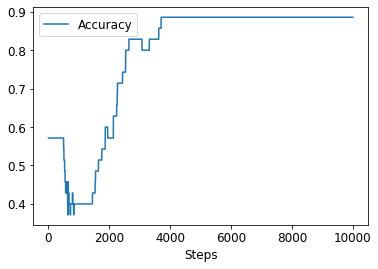

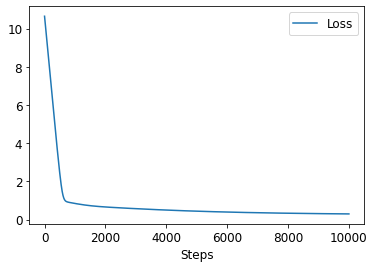

In [12]:
df = DataFrame({'Accuracy': acc_history})
df.index.name = 'Steps'
_ = df.plot(figsize=(6, 4))

df = DataFrame({'Loss': loss_history})
df.index.name = 'Steps'
_ = df.plot(figsize=(6, 4))

**[LRM-13]**

Show weights after the training.

In [13]:
state.params

FrozenDict({
    Dense_0: {
        bias: DeviceArray([-6.0000896], dtype=float32),
        kernel: DeviceArray([[0.23625354],
                     [0.15926503]], dtype=float32),
    },
})

**[LRM-14]**

Plot a chart for predictions.

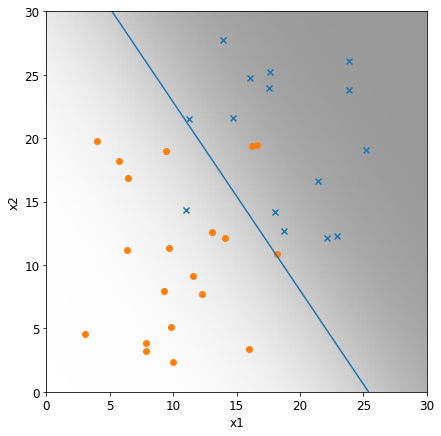

In [14]:
[w1], [w2] = state.params['Dense_0']['kernel']
[b] = state.params['Dense_0']['bias']

train_set0 = [jax.device_get(x).tolist()
              for x, t in zip(train_x, train_t) if t == 0]
train_set1 = [jax.device_get(x).tolist()
              for x, t in zip(train_x, train_t) if t == 1]

fig = plt.figure(figsize=(7, 7))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim([0, 30])
subplot.set_ylim([0, 30])
subplot.set_xlabel('x1')
subplot.set_ylabel('x2')
subplot.scatter([x for x, y in train_set1],
                [y for x, y in train_set1], marker='x')
subplot.scatter([x for x, y in train_set0],
                [y for x, y in train_set0], marker='o')

xs = np.linspace(0, 30, 10)
ys = - (w1*xs/w2 + b/w2)
subplot.plot(xs, ys)

locations = [[x1, x2] for x2 in np.linspace(0, 30, 100) 
                      for x1 in np.linspace(0, 30, 100)]
p_vals = state.apply_fn(
    {'params': state.params}, np.array(locations)).reshape([100, 100])
_ = subplot.imshow(p_vals, origin='lower', extent=(0, 30, 0, 30),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r, alpha=0.4)